# DA5401 Assignment #5
# Visualizing Data Veracity Challenges in Multi-Label Classification

#### Libraries


In [2]:
pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=c0dd5706282c2e936fb775f21ed1717a598655d7d623aaf5fdcfae1c8d00a0b9
  Stored in directory: /root/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff


In [50]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import arff
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xml.etree.ElementTree as ET

## Part A: Preprocessing and Initial Setup

### 1. Data Loading & Dimensionality Check

In [58]:
ARFF_PATH = "/content/yeast.arff"
XML_PATH  = "/content/yeast.xml"

def parse_mulan_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    labels = [elem.attrib['name'] for elem in root.findall(".//{*}label")]
    return labels

label_names = parse_mulan_xml(XML_PATH)

with open(ARFF_PATH, 'r') as f:
    arff_data = arff.load(f)

attributes = [attr[0] for attr in arff_data['attributes']]
df = pd.DataFrame(arff_data['data'], columns=attributes)

Y_cols = label_names
X_cols = [col for col in df.columns if col not in Y_cols]

X = df[X_cols].astype(float).values
Y = df[Y_cols].astype(int).values

### 2. Dimensionality Check

In [59]:
print("Labels from XML:", label_names)
print("Data shape:", df.shape)
print("Attributes:", len(attributes))
print("Feature matrix X:", X.shape)
print("Label matrix   Y:", Y.shape)

Labels from XML: ['Class1', 'Class2', 'Class3', 'Class6', 'Class4', 'Class10', 'Class11', 'Class5', 'Class7', 'Class8', 'Class9', 'Class12', 'Class13', 'Class14']
Data shape: (2417, 117)
Attributes: 117
Feature matrix X: (2417, 103)
Label matrix   Y: (2417, 14)


### 3. Label Selection for Visualization

In [52]:
label_counts = Y.sum(axis=1)
single_label_mask = label_counts == 1
multi_label_mask = label_counts > 1

single_label_data = Y[single_label_mask]
single_label_classes = np.argmax(single_label_data, axis=1)

single_label_counts = np.bincount(single_label_classes, minlength=Y.shape[1])
top_two_single_labels = np.argsort(single_label_counts)[-2:]

multi_label_data = Y[multi_label_mask]
unique_combos, combo_counts = np.unique(multi_label_data, axis=0, return_counts=True)
top_multi_combo = unique_combos[np.argmax(combo_counts)]

color_labels = np.full(Y.shape[0], 'Other', dtype=object)

for i, label_idx in enumerate(top_two_single_labels):
    mask = (Y[:, label_idx] == 1) & (label_counts == 1)
    color_labels[mask] = f'Single_Label_Top_{i+1}'

mask_multi = np.all(Y == top_multi_combo, axis=1)
color_labels[mask_multi] = 'Top_Multi_Label_Combo'

print(np.unique(color_labels, return_counts=True))

(array(['Other', 'Single_Label_Top_2', 'Top_Multi_Label_Combo'],
      dtype=object), array([2148,   32,  237]))


In [53]:
unique_labels, counts = np.unique(color_labels, return_counts=True)

print("Category counts:")
for label, count in zip(unique_labels, counts):
    print(f"{label}: {count}")

Category counts:
Other: 2148
Single_Label_Top_2: 32
Top_Multi_Label_Combo: 237


### 4. Scaling

Distance-based Dimensionality Reduction methods like t-SNE and Isomap rely on pairwise distances. If features have different scales, those with large scale dominate the distances and distort the embedding. Therefore standardization (zero mean, unit variance) is applied to put features on comparable scales.

In [60]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Original shape:", X.shape)
print("Scaled mean (first 5 features):", np.round(X_scaled.mean(axis=0)[:5], 3))
print("Scaled std  (first 5 features):", np.round(X_scaled.std(axis=0)[:5], 3))

Original shape: (2417, 103)
Scaled mean (first 5 features): [ 0. -0. -0.  0. -0.]
Scaled std  (first 5 features): [1. 1. 1. 1. 1.]


## Part B : t-SNE and Veracity Inspection

### t-SNE implementation and Visualisation

t-SNE completed for perplexity = 5
t-SNE completed for perplexity = 10
t-SNE completed for perplexity = 20
t-SNE completed for perplexity = 30
t-SNE completed for perplexity = 40
t-SNE completed for perplexity = 50
t-SNE completed for perplexity = 60
t-SNE completed for perplexity = 70
t-SNE completed for perplexity = 80


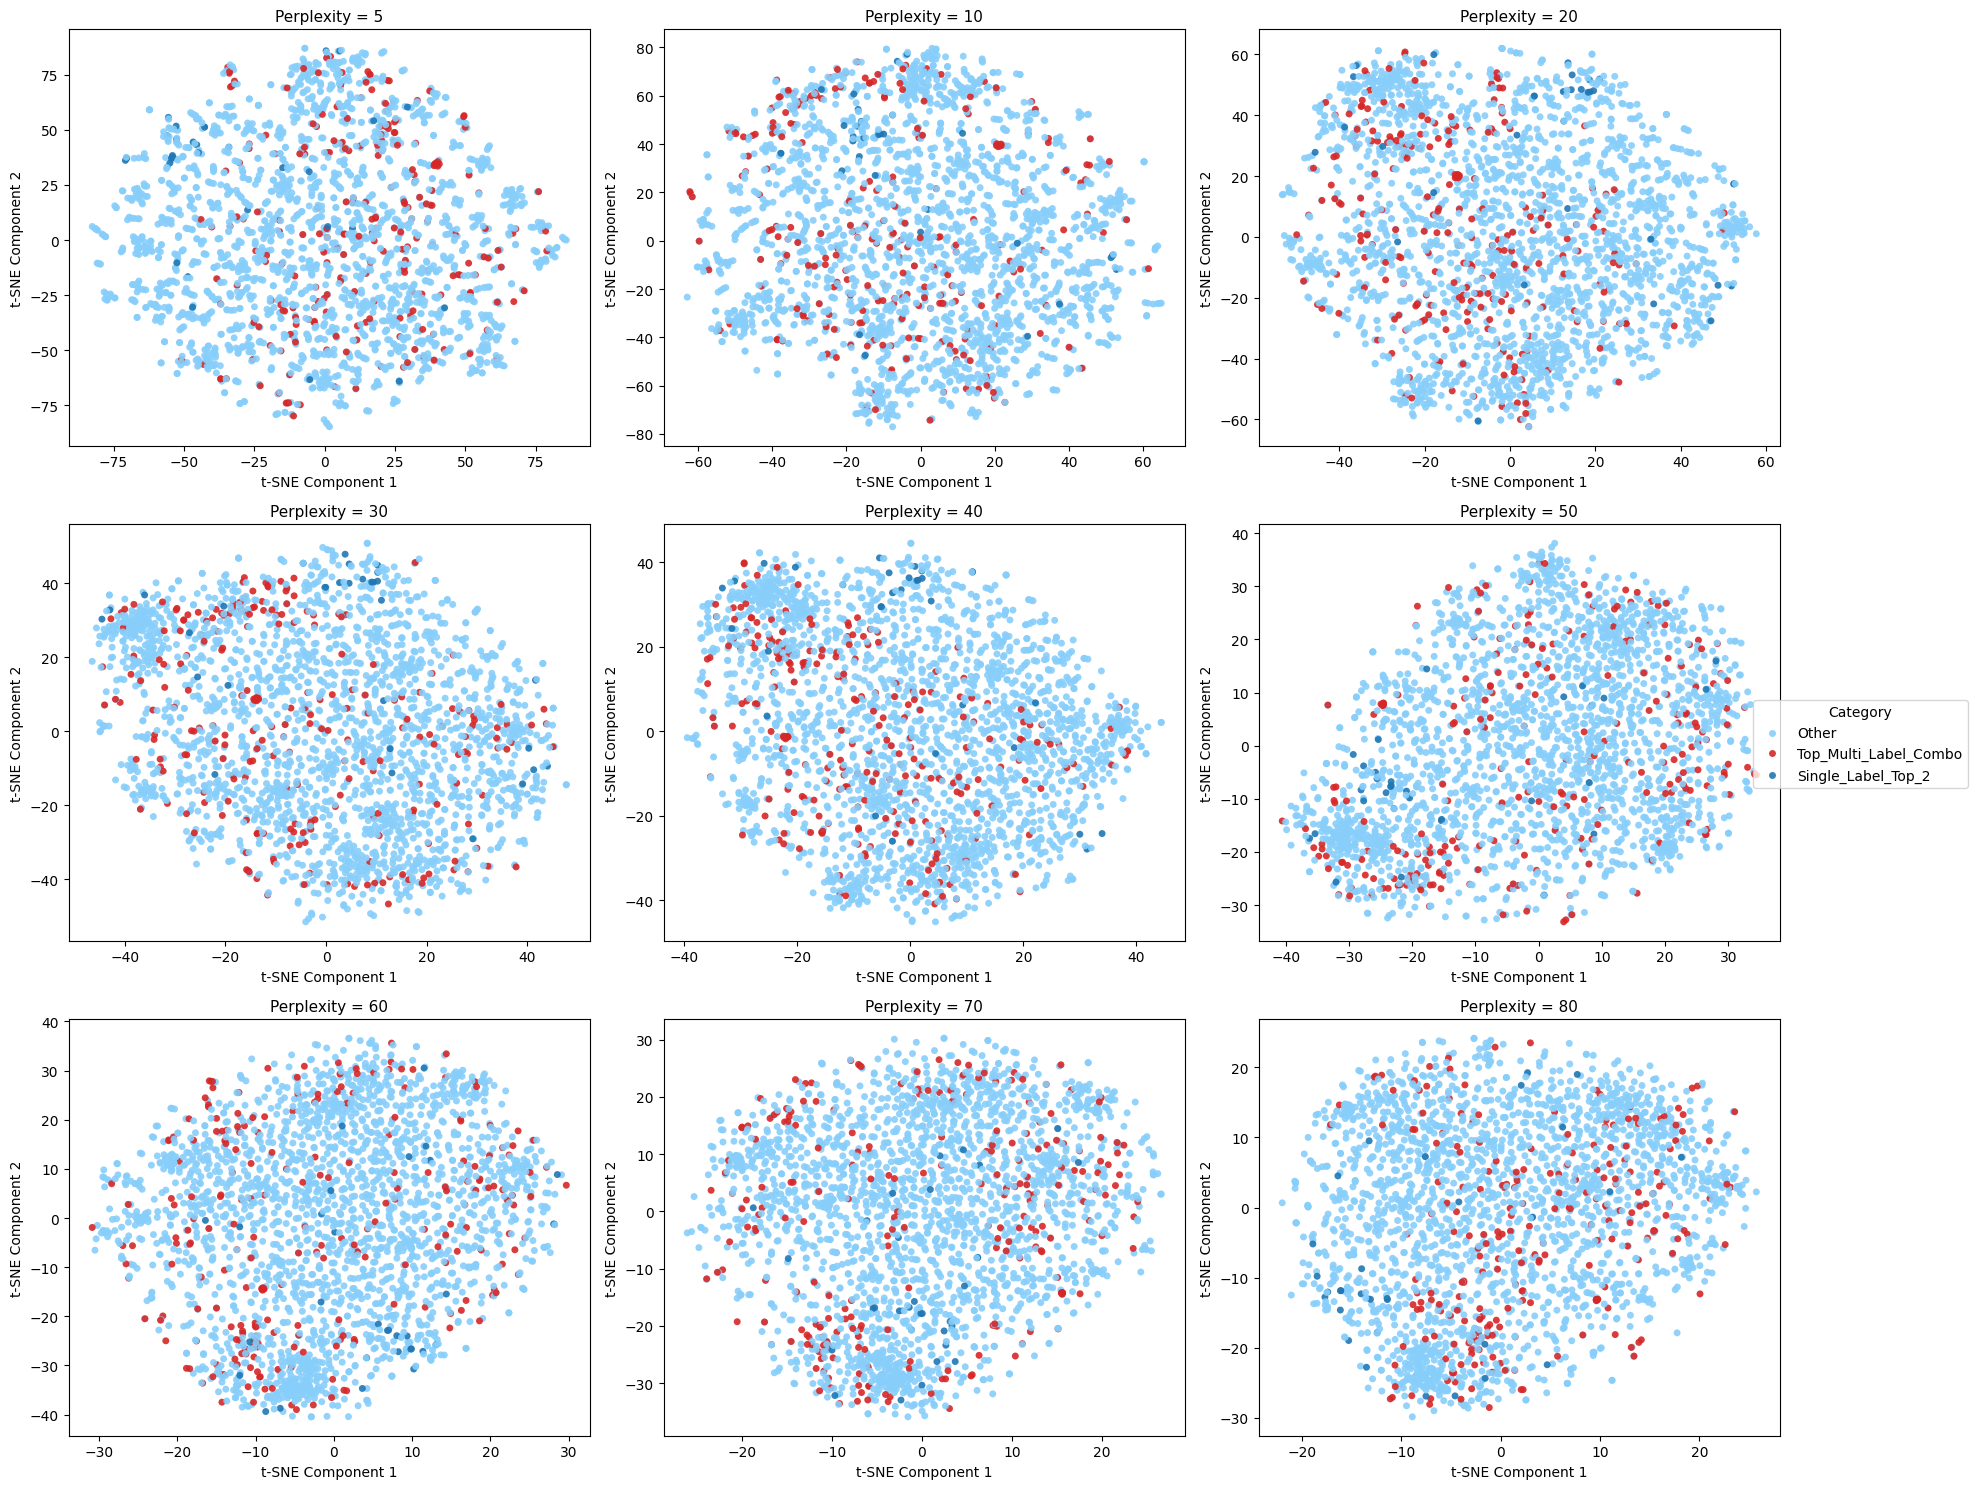

In [61]:
perplexities = [5, 10, 20, 30, 40, 50, 60, 70, 80]
tsne_results = {}

for p in perplexities:
    tsne = TSNE(
        n_components=2,
        perplexity=p,
        learning_rate='auto',
        init='random',
        random_state=42
    )
    tsne_results[p] = tsne.fit_transform(X_scaled)
    print(f"t-SNE completed for perplexity = {p}")

palette_custom = {
    'Single_Label_Top_2': '#1f77b4',
    'Top_Multi_Label_Combo': '#d62728',
    'Other': '#87CEFA'
}

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()


for i, p in enumerate(perplexities):
    ax = axes[i]
    sns.scatterplot(
        x=tsne_results[p][:, 0],
        y=tsne_results[p][:, 1],
        hue=color_labels,
        palette=palette_custom,
        s=25,
        edgecolor='none',
        alpha=0.9,
        ax=ax
    )
    ax.set_title(f"Perplexity = {p}", fontsize=11)
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.legend_.remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Category", loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
plt.show()


### Interpretation:

#### Perplexity = 30 is chosen as the final choice.

- it strikes the perfect balance for this functional category analysis by providing sufficient resolution to identify all three inspection categories while maintaining biological interpretability and statistical robustness.
- The visualization clearly reveals the complex relationships between different functional states without introducing visual artifacts from inappropriate parameter choices.
- Perplexity < 20 shows excessive fragmentation, making the "Other" category look artificially subdivided and Perplexity > 40 is oversmooth, potentially merging biologically distinct categories and hiding important local patterns



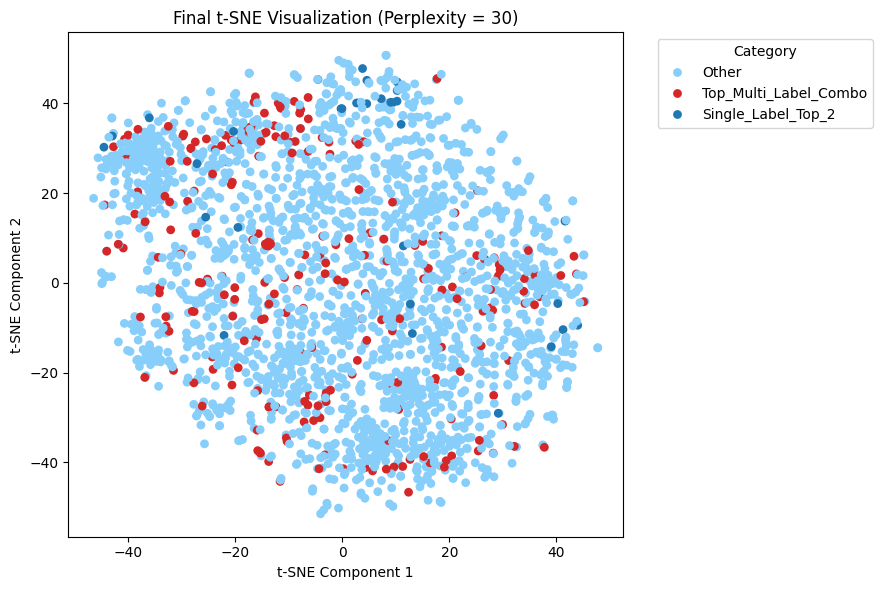

In [62]:
final_p = 30
final_tsne = tsne_results[final_p]
plt.figure(figsize=(9, 6))
sns.scatterplot(
    x=final_tsne[:, 0],
    y=final_tsne[:, 1],
    hue=color_labels,
    palette=palette_custom,
    s=40,
    edgecolor='none'
)
plt.title(f"Final t-SNE Visualization (Perplexity = {final_p})", fontsize=12)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Veracity Inspection Analysis

### 1. Noisy/Ambiguous Labels

- There are several regions where red points (Top_Multi_Label_Combo) are densely embedded within light-blue clusters (Other), especially:
- Around the center and lower-central portions of the plot.
- In the upper-left region, where small red clusters appear surrounded by light-blue points.
- These embedded red points suggest label ambiguity or misclassification — samples that likely share strong feature similarity with the dominant class but are labeled differently.
- Such cases often arise from multi-label overlaps or borderline feature vectors in high-dimensional space that t-SNE has projected close together.


Interpretation: These embedded points suggest
- Annotation Error: Potential incorrect labeling
- Biological Ambiguity: Cells in transitional or hybrid states that share core functional programs across classes

### 2. Outliers

- A few isolated light-blue points are visible far from the main data mass: Bottom-left corner (x < -40) and bottom-right outskirts (x > 40) contain sparse, scattered light-blue samples.
- These may represent rare expression patterns, measurement errors, or unique, underrepresented feature combinations.
- Outliers could also correspond to samples with missing or noisy data, or atypical distributions that t-SNE projects far from the main manifold due to their low similarity to the bulk of the dataset.

Hypothesis on Unusual Expression Patterns:
- Rare Cell States: Cells undergoing unique biological processes (specific stress response, unusual cell cycle phase, rare sub-type)
- Technical Artifacts: Potential doublets (two cells sequenced as one) or sequencing errors
- Extreme Expression: Cells with dominant high/low expression of few genes that distort distance calculations

### 3. Hard-to-Learn Samples

- The central region and mid-lower area show heavy mixing of red, dark-blue, and light-blue points, indicating no clear separability among the three categories.
- In these zones, feature overlap is high — meaning the latent structure offers no clear linear or non-linear boundaries between classes.

A simple classifier (like Logistic Regression or a shallow Decision Tree) would struggle here since:

- Non-Linear Separability: No straight line/plane can separate the classes effectively in this region
- Feature Overlap: Gene expression patterns are too similar between classes, lacking clear discriminatory signals
- High Model Complexity Required: Requires complex, non-linear decision boundaries beyond simple classifier capabilities
- Shared Functional Signature: Cells in this region likely share core functional programs, making class distinction difficult

## Part C : Isomap and Manifold Learning

Fundamental Difference between Isomap and t-SNE:

- Isomap:
  - Preserves **global geometric structure** of the data.
  - Constructs a neighborhood graph and approximates geodesic distances.
  - Good for capturing manifold shape, global relationships between clusters.

- t-SNE:
  - Preserves **local neighborhood structure**.
  - Focuses on maintaining pairwise similarities in small neighborhoods.
  - Often exaggerates separation between clusters and collapses distances globally.

➡ Isomap can be used to see the overall manifold, and t-SNE to explore local cluster density, outliers,
   and hard-to-learn samples.


### Isomap Implementation and Visualisation

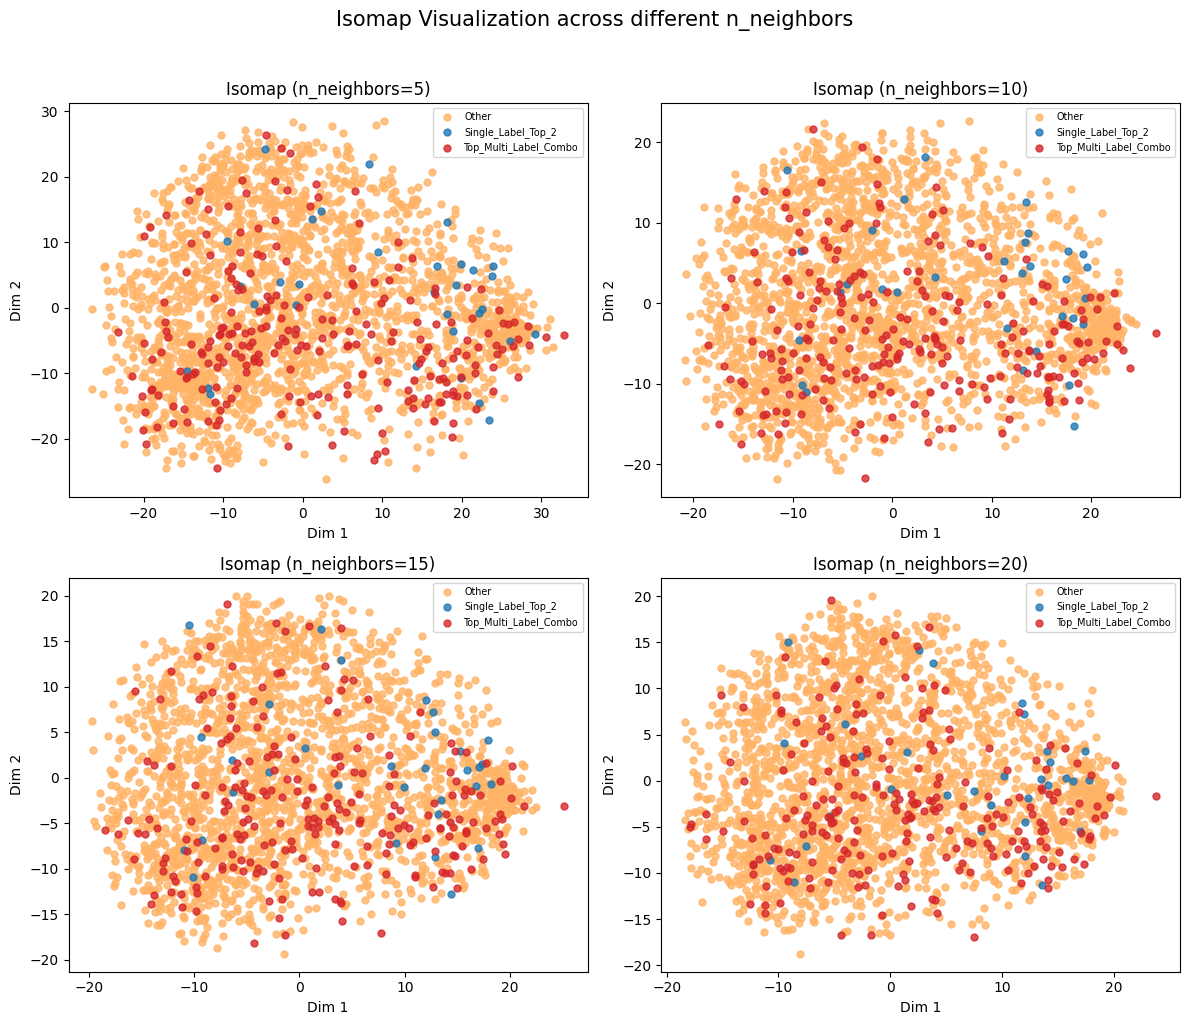

In [63]:
n_neighbors_list = [5, 10, 15, 20]

palette_custom = {
    'Single_Label_Top_2': '#1f77b4',
    'Top_Multi_Label_Combo': '#d62728',
    'Other': '#FFB366'
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, n in enumerate(n_neighbors_list):
    Z_tmp = Isomap(n_neighbors=n, n_components=2).fit_transform(X_scaled)
    ax = axes[i]
    for cat in np.unique(color_labels):
        idx = color_labels == cat
        ax.scatter(Z_tmp[idx, 0], Z_tmp[idx, 1],
                   s=25, alpha=0.8, label=cat, c=palette_custom[cat])
    ax.set_title(f"Isomap (n_neighbors={n})", fontsize=12)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(fontsize="x-small")

plt.suptitle("Isomap Visualization across different n_neighbors", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()


### Interpretation:

#### n_neighbors = 10 is chosen as the final choice

- It achieves the ideal balance, producing well-defined, distinct clusters without being overly fragmented. This provides the clearest separation of the major functional categories (the different colors), making it the most interpretable and useful for analysis.

- n_neighbors < 10 create excessive segmentation, breaking the data into many small, tight clusters. This "over-clustering" obscures the broader, biologically meaningful groups and is more sensitive to local noise.

- n_neighbors > 10 over-smooths the data, causing the distinct clusters to begin merging into blobs. This results in a loss of important detail and fails to capture the clear boundaries between different categories.

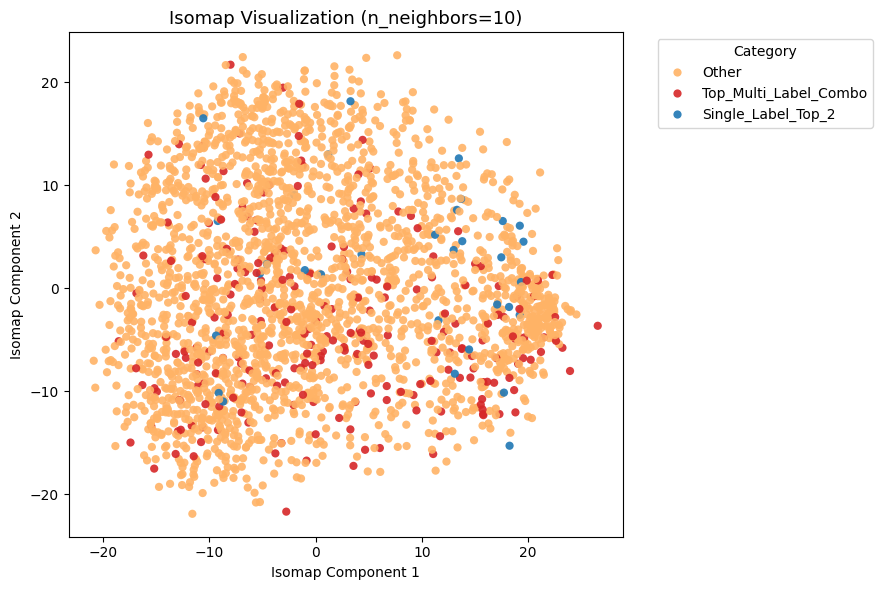

In [65]:
n_neighbors_final = 10
isomap = Isomap(n_neighbors=n_neighbors_final, n_components=2)
X_isomap = isomap.fit_transform(X_scaled)

plt.figure(figsize=(9, 6))
sns.scatterplot(
    x=X_isomap[:, 0],
    y=X_isomap[:, 1],
    hue=color_labels,
    palette=palette_custom,
    s=35,
    edgecolor='none',
    alpha=0.9
)
plt.title(f"Isomap Visualization (n_neighbors={n_neighbors_final})", fontsize=13)
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 3. Comparison and Curvature Analysis

### Isomap vs t-SNE Visualization

**Global Structure Revelation: Isomap is Superior for Global Structure**

Based on the comparison between the two visualizations:
- Global Structure: Isomap provides excellent preservation of global structure with clear large-scale clusters and relationships, while t-SNE focuses primarily on local neighborhoods and performs poorly at maintaining global structure.
- Cluster Separation: Isomap creates well-defined clusters with clear boundaries, whereas t-SNE shows mixed results with some cluster separation but significant overlap between groups.
- Distance Preservation: Isomap effectively preserves geodesic distances along the data manifold, while t-SNE only maintains local distances and severely distorts global distances.
- Outlier Visibility: Isomap clearly displays isolated points making outliers easily identifiable, while t-SNE's more compressed layout makes outlier detection less straightforward.


**Conclusion:** Isomap is significantly better at revealing the **global structure** and **true geometric relationships** between different functional categories in the gene expression data.

### Data Manifold Analysis

#### Manifold:
- A manifold is a lower-dimensional, non-linear shape embedded within a high-dimensional space.
- The "curvature" of a manifold defines its complexity. A highly curved and folded manifold means the relationships between data points are complex and non-linear.
- Manifold complexity directly impacts classification difficulty. A simple, flat manifold is easy for any classifier to separate. A complex, folded one requires a powerful non-linear model.

#### Manifold Complexity Assessment:

The Isomap plot suggests a MODERATELY curved, structured manifold

Evidence of Complex Curvature:
- The data forms distinct, non-linearly separable clusters rather than a simple Gaussian distribution
- The manifold exhibits continuous curvature rather than sharp, complex folding
- Data points follow a smooth trajectory through the expression space
- This represents a simplified 2D projection of what is likely a higher-dimensional curved surface



#### Relationship to Classification Difficulty

#### Favorable Factors for Classification:

- The clear separation between major arcs suggests distinct expression programs
- Continuous progression indicates logical transitions between states
- Moderate curvature means a non-linear classifier could successfully learn decision boundaries

#### Challenging Factors:

- The curved nature explains why simple linear classifiers would struggle
- Boundary regions between categories represent gradual transitions rather than sharp divides
- Overlap zones (particularly between adjacent arcs) contain ambiguous samples

#### Final Insight:
This represents a moderately complex manifold - curved enough to challenge linear methods but structured enough that non-linear classifiers should achieve good performance with appropriate capacity.
